In [230]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

데이터 로드 및 시트 merge를 통한 열 추가

In [231]:
data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='야드크레이인_작업이력')
scd_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='반출입_예정컨테이너')
cbd_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='장치장_전')
cad_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='장치장_후')
quay_work_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='본선크레인_작업이력')

# int 타입임
print(quay_work_data['작업완료시간'].dtype)
quay_work_data['작업완료시간'] = quay_work_data['작업완료시간'].astype(str).replace('^2020', '2023', regex=True)
print(quay_work_data.shape)
merge_list = []
# data, container_before_data, container_after_data merge
ycb_common_values = data['컨테이너번호'].isin(quay_work_data['컨테이너번호']).sum() # 6103개
print('ycb_common_values', ycb_common_values)
# data_quay_work_common_df = pd.merge(data, quay_work_data, on='컨테이너번호')
# data_scd_work_common_df = pd.merge(data, scd_data, on='컨테이너번호')
data_cad_data_common_df = pd.merge(data, cad_data, on='컨테이너번호')
# merge_list.append(data_quay_work_common_df)
# merge_list.append(data_scd_work_common_df)
# merge_list.append(data_cad_data_common_df)

common_df = data_cad_data_common_df
print(common_df.shape)

int64
(2744, 14)
ycb_common_values 3212
(6103, 40)


데이터 전처리(숫자화, na 데이터 처리, 날짜 형 변환)

In [232]:
# #데이터 전처리(data_quay)
# common_df['작업코드_x'] = common_df['작업코드_x'].replace({'VU': 1, 'VL': 2, 'GR': 3, 'GD': 4, 'TM':5,'TS':6})
# common_df['장비번호'] = common_df['장비번호'].replace({'Y02': 1})
# #시간 타입 통합
# common_df['작업생성시간'] = pd.to_datetime(common_df['작업생성시간'], format='%Y%m%d%H%M%S')
# common_df['작업완료시간_x'] = pd.to_datetime(common_df['작업완료시간_x'], format='%Y%m%d%H%M%S')
# common_df['작업완료시간_y'] = pd.to_datetime(common_df['작업완료시간_y'], format='%Y%m%d%H%M%S')
# # 외부트럭에 1 넣기
# common_df['야드트럭(번호)'] = common_df['야드트럭(번호)'].fillna(1)
# print('common_df',common_df)
# print('작업생성시간',common_df['작업생성시간'].dtype)
# print('작업완료시간_x',common_df['작업완료시간_x'].dtype)
# print('작업완료시간_y',common_df['작업완료시간_y'].dtype)
# print('작업완료시간_y',common_df['작업완료시간_y'])
# common_df['작업+대기시간'] = common_df['작업완료시간_x'] -common_df['작업생성시간']



# # data_반출입_예정(merge)
# common_df['작업코드'] = common_df['작업코드'].replace({'VU': 1, 'VL': 2, 'GR': 3, 'GD': 4, 'TM':5,'TS':6})
# common_df['장비번호'] = common_df['장비번호'].replace({'Y02': 1})

# # 외부트럭에 1 넣기
# common_df['야드트럭(번호)'] = common_df['야드트럭(번호)'].fillna(1)
# # 시간 타입 통합
# common_df['작업생성시간'] = pd.to_datetime(common_df['작업생성시간'], format='%Y%m%d%H%M%S')
# common_df['작업완료시간'] = pd.to_datetime(common_df['작업완료시간'], format='%Y%m%d%H%M%S')
# common_df['작업완료시간'] = pd.to_datetime(common_df['작업완료시간'], format='%Y%m%d%H%M%S')
# # datetime64[ns] 타입의 03/23/2023 12:43:45로 변환
# common_df['시간'] = pd.to_datetime(common_df['시간'], format='%m/%d/%Y %H:%M:%S')
# # datetime 형태 일치
# common_df['시간'] = common_df['시간'].dt.strftime('%Y-%m-%d %H:%M:%S')
# print(common_df['시간'])
# common_df['시간'] = pd.to_datetime(common_df['시간'])

# print('common_df',common_df)
# print('작업생성시간',common_df['작업생성시간'].dtype)
# print('작업완료시간',common_df['작업완료시간'].dtype)
# print('작업완료시간',common_df['작업완료시간'].dtype)
# print('작업완료시간',common_df['작업완료시간'])
# common_df['작업+대기시간'] = common_df['작업완료시간'] -common_df['작업생성시간']
# # print('n_data', n_data)
# print('common_df',common_df.info())
# print(n_data.isna().sum())

# data_after merge
common_df['작업코드'] = common_df['작업코드'].replace({'VU': 1, 'VL': 2, 'GR': 3, 'GD': 4, 'TM':5,'TS':6})
common_df['장비번호'] = common_df['장비번호'].replace({'Y02': 1})
common_df['풀(F)공(M)'] = common_df['풀(F)공(M)'].replace({'M':1, 'F':2})
common_df['수출/수입'] = common_df['수출/수입'].replace({'X':1,'I':2,'S':3,'M':4})
    
#시간 타입 통합
common_df['작업생성시간'] = pd.to_datetime(common_df['작업생성시간'], format='%Y%m%d%H%M%S')
common_df['작업완료시간'] = pd.to_datetime(common_df['작업완료시간'], format='%Y%m%d%H%M%S')

# 외부트럭에 1 넣기
common_df['야드트럭(번호)'] = common_df['야드트럭(번호)'].fillna(1)
print('common_df',common_df)
print('작업생성시간',common_df['작업생성시간'].dtype)
print('작업완료시간',common_df['작업완료시간'].dtype)

common_df['작업+대기시간'] = common_df['작업완료시간'] -common_df['작업생성시간']
print(common_df[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간']])
print(common_df['작업+대기시간'].isna().sum())
print('common_df',common_df.info())
# common_df = common_df[-1000:]
print(common_df.shape)



common_df            컨테이너번호  작업코드 선박코드_x  년도_x  항차_x 블록_x  베이_x  로우_x  티어_x 블록2  ...   
0     CKJN9049578     1   HHTK  2023    19   7E   6.0   NaN   NaN  7E  ...  \
1     HCWX3125579     1   PCHM  2023     4   4R  27.0   NaN   NaN  4R  ...   
2     LMEC0254366     1   MXMR  2023    16   4L   3.0   NaN   NaN  4L  ...   
3     WIQF7935938     1   CAET  2023    11   1A  12.0   NaN   NaN  1A  ...   
4     WIQF7935938     6   CAET  2023    11   1A  12.0   3.0   3.0  1A  ...   
...           ...   ...    ...   ...   ...  ...   ...   ...   ...  ..  ...   
6098  FRKE6756314     3   HAKT  2023     2   4D  15.0   NaN   NaN  4D  ...   
6099  JPPT1528912     6   PCHM  2023     4   7A  13.0   8.0   4.0  7A  ...   
6100  GZEH5361207     6   KMDF  2023     3   3R  14.0   1.0   2.0  3R  ...   
6101  VNCL0771568     1   DJVS  2023    12   3H   3.0   NaN   NaN  3H  ...   
6102  ONCF8625600     6   MIBH  2023     7   8A   9.0   5.0   3.0  8A  ...   

      목적지(코드)  블록_y  베이_y  로우_y 티어_y  수출/수입  Unnamed:

(2000, 41)
(4103, 41)


d:\김형찬\teamproject2\TeamProject_PCTC\pctc-da\Congest_project\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
d:\김형찬\teamproject2\TeamProject_PCTC\pctc-da\Congest_project\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


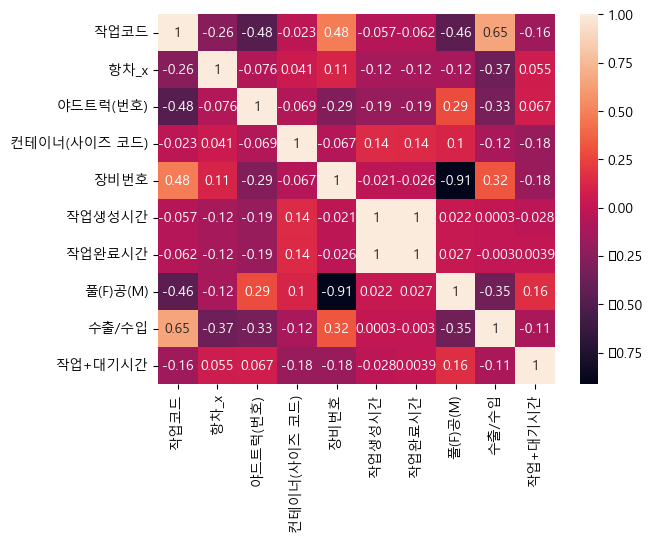

In [224]:
# data, quay merge
common_df_truck_out = common_df[common_df['야드트럭(번호)'] != 1]
print(common_df_truck_out.shape)
common_df_truck_in = common_df[common_df['야드트럭(번호)'] == 1]
print(common_df_truck_in.shape)
correlation_matrix = common_df_truck_out[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간', '풀(F)공(M)', '수출/수입','작업+대기시간']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# # data, 반출입_예정
# common_df_truck_out = common_df[common_df['야드트럭(번호)'] != 1]
# print(common_df_truck_out.info())
# common_df_truck_in = common_df[common_df['야드트럭(번호)'] == 1]
# print(common_df_truck_in.info())
# correlation_matrix = common_df_truck_out[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간', '작업완료시간','작업+대기시간','시간','무게']].corr()
# sns.heatmap(correlation_matrix, annot=True)
# plt.show()

# # data, 장치장 후 merge
# common_df_truck_out = common_df[common_df['야드트럭(번호)'] != 1]
# print(common_df_truck_out.info())
# common_df_truck_in = common_df[common_df['야드트럭(번호)'] == 1]
# print(common_df_truck_in.info())
# correlation_matrix = common_df_truck_out[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간', '작업완료시간','작업+대기시간','수출/수입', '베이_x', '로우_x', '티어_x']].corr()
# sns.heatmap(correlation_matrix, annot=True)
# plt.show()

정규분포 분석

0      0 days 00:07:13
1      0 days 00:06:21
2      0 days 00:09:29
3      0 days 00:04:43
5      0 days 00:05:00
             ...      
6087   0 days 00:22:17
6090   0 days 00:05:00
6091   0 days 00:05:00
6096   0 days 00:22:22
6101   0 days 00:21:38
Name: 작업+대기시간, Length: 2000, dtype: timedelta64[ns]


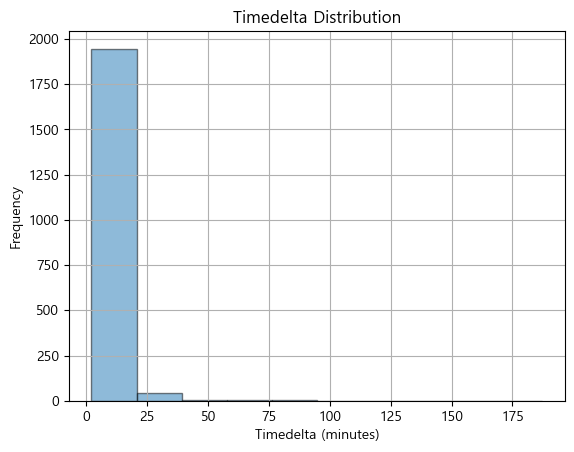

In [225]:
data = common_df_truck_out['작업+대기시간']
print(data)
# Timedelta 값을 숫자 값으로 변환
data = data.dt.total_seconds() / 60  # timedelta 값을 분으로 변환

# 정규분포 그래프 그리기
plt.hist(data, bins=10, edgecolor='black', alpha=0.5)
plt.xlabel('Timedelta (minutes)')
plt.ylabel('Frequency')
plt.title('Timedelta Distribution')
plt.grid(True)
plt.show()

이상치 분석

In [226]:
data = common_df_truck_out['작업+대기시간']
mean = data.mean()
std = data.std()
threshold = mean + (5 * std)
outliers = common_df_truck_out[common_df_truck_out['작업+대기시간'] > threshold]
print('outliers',outliers['작업+대기시간'])
print(len(outliers))
print(common_df_truck_out.shape)
# print(common_df_truck_out['작업+대기시간'])
# print(common_df_truck_out['작업+대기시간'].dtype)


outliers 2344   0 days 01:07:26
2703   0 days 03:07:16
4942   0 days 00:44:58
4960   0 days 00:53:57
4980   0 days 00:54:57
5047   0 days 01:08:18
5050   0 days 01:06:15
5223   0 days 01:31:20
5258   0 days 01:34:39
Name: 작업+대기시간, dtype: timedelta64[ns]
9
(2000, 41)


이상치 제거

In [205]:
common_df_truck_out = common_df_truck_out.drop(outliers.index, axis=0)
print(common_df_truck_out)


           컨테이너번호  작업코드 선박코드_x  년도_x  항차_x 블록_x  베이_x  로우_x  티어_x 블록2  ...   
0     CKJN9049578     1   HHTK  2023    19   7E   6.0   NaN   NaN  7E  ...  \
1     HCWX3125579     1   PCHM  2023     4   4R  27.0   NaN   NaN  4R  ...   
2     LMEC0254366     1   MXMR  2023    16   4L   3.0   NaN   NaN  4L  ...   
3     WIQF7935938     1   CAET  2023    11   1A  12.0   NaN   NaN  1A  ...   
5     YDRH3310827     5   HPUS  2023    29   1R  17.0   NaN   NaN  1R  ...   
...           ...   ...    ...   ...   ...  ...   ...   ...   ...  ..  ...   
6087  CFNG7024213     1   DJVS  2023    12   5A  21.0   NaN   NaN  5A  ...   
6090  XOKM4171394     5   HMMM  2023     3   1P  27.0   NaN   NaN  1P  ...   
6091  XOKM4171394     5   HMMM  2023     3   4Y  26.0   NaN   NaN  4Y  ...   
6096  OFGG4630734     1   DJVS  2023    12   5A  21.0   NaN   NaN  5A  ...   
6101  VNCL0771568     1   DJVS  2023    12   3H   3.0   NaN   NaN  3H  ...   

      블록_y  베이_y  로우_y  티어_y 수출/수입  Unnamed: 15  Unnamed: 16 Un

예측모델 및 그래프 생성

C:\Users\SW\AppData\Local\Temp\ipykernel_17404\2739784382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df2['작업생성시간'] = common_df2['작업생성시간'].astype('int64') // 10**9
C:\Users\SW\AppData\Local\Temp\ipykernel_17404\2739784382.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df2['작업+대기시간'] = common_df2['작업+대기시간'].dt.total_seconds() /60.0
C:\Users\SW\AppData\Local\Temp\ipykernel_17404\2739784382.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

                  작업생성시간        예측값
228  2023-03-23 08:14:58   9.537333
227  2023-03-23 08:15:01   9.537333
221  2023-03-23 08:15:32  24.060044
272  2023-03-23 08:24:03  63.899800
8    2023-03-23 08:24:07  11.544833
...                  ...        ...
5971 2023-03-23 21:21:45   5.000000
6034 2023-03-23 21:21:46   5.000000
6099 2023-03-23 21:23:33   5.000000
5182 2023-03-23 21:23:39   5.000000
5937 2023-03-23 21:23:51   5.000000

[1221 rows x 2 columns]
                           예측값
작업생성시간                        
2023-03-23 08:10:00  24.060044
2023-03-23 08:20:00  63.899800
2023-03-23 08:30:00  40.652000
2023-03-23 08:40:00  80.223167
2023-03-23 08:50:00  26.097833
...                        ...
2023-03-23 20:40:00  15.839333
2023-03-23 20:50:00  18.236167
2023-03-23 21:00:00  15.995833
2023-03-23 21:10:00  12.982125
2023-03-23 21:20:00   5.000000

[80 rows x 1 columns]


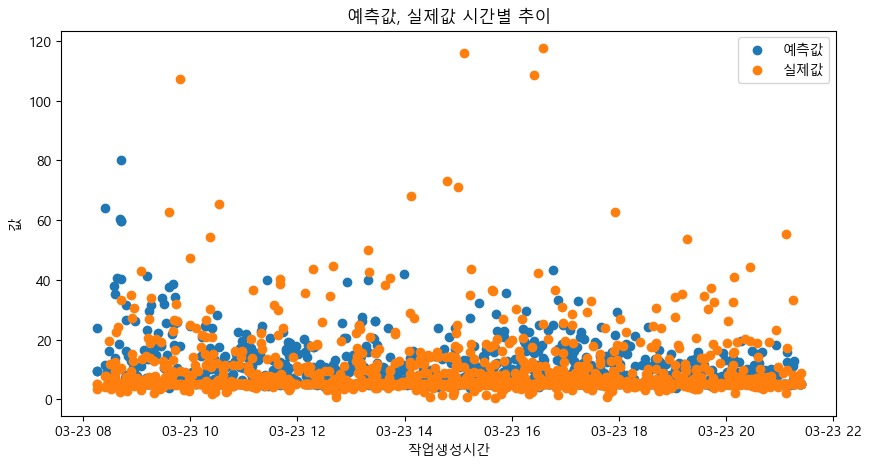

In [237]:
common_df2 = common_df
common_df2['풀(F)공(M)'] = common_df2['풀(F)공(M)'].astype('int64')
common_df2 = common_df2.dropna(subset=['작업+대기시간'])

######################## x 축에 시간 넣기 위한 작업#######################
# 작업생성시간을 Unix timestamp로 변환
common_df2['작업생성시간'] = common_df2['작업생성시간'].astype('int64') // 10**9
#########################################################################
common_df2['작업+대기시간'] = common_df2['작업+대기시간'].dt.total_seconds() /60.0

common_df2['풀(F)공(M)'] = common_df2['풀(F)공(M)'].astype('int64')
common_df2 = common_df2.dropna(subset=['작업+대기시간'])
common_df_complete = common_df2
#  # 특성과 목표 변수 설정
X = common_df_complete[['작업생성시간','작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '풀(F)공(M)', '수출/수입']]
y = common_df_complete['작업+대기시간']
# 데이터를 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 랜덤 포레스트 모델 객체 생성 100개 예측
model = RandomForestRegressor(n_estimators=100, random_state=42)
# 모델 훈련
model.fit(X_train, y_train)

# 모델 예측
predictions = model.predict(X_test)


###########################################################################
# x 축에 시간 넣기 위한 작업
# 예측값을 X_test에 추가
X_test_with_predictions = X_test.copy()
X_test_with_predictions['예측값'] = predictions
X_test_with_predictions['실제값'] = y_test
X_test_with_predictions['작업생성시간'] = pd.to_datetime(X_test_with_predictions['작업생성시간'], unit='s')

# 작업생성시간 별로 정렬
X_test_with_predictions.sort_values('작업생성시간', inplace=True)
X_test_with_predictions= X_test_with_predictions[['작업생성시간', '예측값']]
# 결과 출력
print(X_test_with_predictions)
# Unix timestamp를 datetime으로 변환
grouped_df = X_test_with_predictions.groupby(pd.Grouper(key='작업생성시간', freq='10min')).max()
print(grouped_df)

plt.figure(figsize=(10, 5))
plt.scatter(X_test_with_predictions['작업생성시간'], X_test_with_predictions['예측값'], label='예측값')
plt.scatter(X_test_with_predictions['작업생성시간'], y_test, label='실제값')
plt.xlabel('작업생성시간')
plt.ylabel('값')
plt.title('예측값, 실제값 시간별 추이')
plt.legend()
plt.show()


모델 평가

In [238]:
# 실제값과 예측값의 차이 계산
errors = y_test - predictions

# 평균 오차 계산
mean_error = np.mean(errors)

# 평균 절대 오차 계산
mean_absolute_error = np.mean(np.abs(errors))

# 평균 제곱 오차 계산
mean_squared_error = np.mean(errors**2)

# 평균 오차 및 정확도 출력
print("평균 오차:", mean_error)
print("평균 절대 오차:", mean_absolute_error)
print("평균 제곱 오차:", mean_squared_error)

평균 오차: -0.05440456961290256
평균 절대 오차: 3.361090243273577
평균 제곱 오차: 54.62638244807434
